# Infectious disease transmission on a network

### Nic Geard -- 15 November 2018

Many infectious diseases spread via person-to-person contact, and the patterns of contact among members of a population can usefully be thought of as a network in which nodes represent people and edges represent contact - and the possibility of transmission - between pairs of people.

Early estimation of pathogen characteristics during an outbreak of a novel disease are an important part of planning an effective response. Accurate estimation can be hampered by the fact that less severe or asymptomatic cases of infection may not be observed. In addition, we never have access to the full contact network underlying disease transmission. Thus, techniques are needed that can provide more accurate inference of epidemiological characteristcs of an outbreak from partial observation of cases and contacts.

We first simulate a contact network, here, specified as a collection of connected communities in which contact is more likely between members of the same community than members of different communities. For example, a population of households.

We then simulate an infectious disease spreading on this network, following introduction of a single infectious person. The disease follows a standard **S**usceptible - **I**nfectious - **R**ecovered (SIR) model, in which each infectious individual has specified probability of $g$ of recovering on a given day, or a specified probability $q$ of infecting each of their susceptible network neighbours.

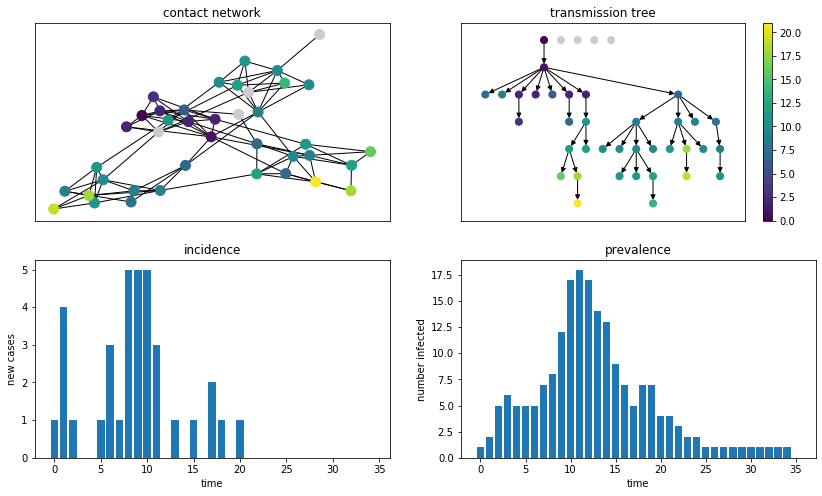

In [2]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# construct network (connected communities)
num_comms = 4   # number of communities
comm_size = 10  # nodes per community
N = num_comms * comm_size # population size
p_in = 0.5      # probability of within-community edges
p_out = 0.025   # probability of between-community edges
G = nx.random_partition_graph([comm_size] * num_comms, p_in, p_out)

# transmission model parameters 
q = 0.18   # probability of transmission
g = 0.2    # probability of recovery

# initialise network attributes
nx.set_node_attributes(G, 'S', 'state')     # disease state
nx.set_node_attributes(G, -1, 't_I')        # time of infection
nx.set_node_attributes(G, None, 's_I')      # source of infection

# seed population with a single infection
seed_node = np.random.randint(N)
G.nodes[seed_node]['state'] = 'I'
G.nodes[seed_node]['t_I'] = 0
G.nodes[seed_node]['s_I'] = None

# set next state attribute equal to current state
nx.set_node_attributes(G, nx.get_node_attributes(G, 'state'), 'next_state')


# simulate an outbreak on the network
t = 0      # time step
v_SI = []  # vector to keep track of incidence (new infections occurring per time step)
v_I = []   # vector to keep track of prevalence (current number of infections in each time step)

# iterate until outbreak ends
while(True):
    t += 1  # increment time
    
    # infectious nodes
    n_I = [n for n,v in G.nodes(data=True) if v['state'] == 'I']
    # track prevalence
    v_I.append(len(n_I))
    
    # end if no further infectious nodes
    if not n_I:
        break

    new_cases = 0  # incidence
        
    # consider each infectious node in turn
    for i in np.random.permutation(n_I):
        # check for recovery
        if np.random.rand() < g:
                G.nodes[i]['next_state'] = 'R'
                continue  # no onward transmission after recovery
        # otherwise, check for infection of neighbours
        for j in G[i]:
            # check next_state rather than state, so s_I is *first* source
            if G.nodes[j]['next_state'] == 'S' and np.random.rand() < q:
                new_cases += 1
                G.nodes[j]['next_state'] = 'I'
                # keep track of time and source of infection
                G.nodes[j]['t_I'] = t
                G.nodes[j]['s_I'] = i
    # update current state
    nx.set_node_attributes(G, nx.get_node_attributes(G, 'next_state'), 'state')  

    # track incidence
    v_SI.append(new_cases)

# create some plots to visualise the output of our simulation ###################

# plot output
plt.figure(figsize=(14,8))

# use viridis colour map, with grey for uninfected nodes
my_cmap = plt.cm.get_cmap('viridis')
my_cmap.set_under('0.8')

# draw the contact network (nodes coloured by infection time)
ax = plt.subplot(221)
nx.draw_networkx(G, 
                 with_labels=False,
                 node_size=100,
                 node_color=list(nx.get_node_attributes(G, 't_I').values()),
                 pos=nx.spring_layout(G, seed=1234),
                 cmap=plt.cm.viridis, vmin=0)
ax.set_title('contact network')
ax.set_xticks([])
ax.set_yticks([])    

# draw the transmission tree
ax = plt.subplot(222)
tree = nx.DiGraph()
tree.add_nodes_from([(k, v) for k, v in G.nodes(data=True)])# if v['s_I'] != None])
tree.add_edges_from([(v['s_I'], i) for i, v in G.nodes(data=True) if v['s_I'] != None])
pos=nx.nx_agraph.graphviz_layout(tree, prog='dot')
nodes = nx.draw_networkx_nodes(tree, pos=pos, node_size=50, #with_labels=False, 
                 node_color=list(nx.get_node_attributes(tree, 't_I').values()),
                 cmap=plt.cm.viridis, vmin=0)
edges = nx.draw_networkx_edges(tree, pos=pos, node_size=50)
plt.colorbar(nodes)
ax.set_title('transmission tree')
ax.set_xticks([])
ax.set_yticks([])

# plot incidence over time
ax = plt.subplot(223)
ax.bar(range(len(v_SI)), v_SI)
ax.set_title('incidence')
ax.set_xlabel('time')
ax.set_ylabel('new cases')

# plot prevalence over time
ax = plt.subplot(224)
ax.bar(range(len(v_I)), v_I)
ax.set_title('prevalence')
ax.set_xlabel('time')
ax.set_ylabel('number infected')

plt.show()

This provides us with a *true* picture of the disease outbreak. As mentioned above, we are very unlikely to have this information, so let's degrade our data bit.

1. We may know which community (eg, household) each individual belongs to, and can assume that members of a household each contact one another, but may only be able to estimate patterns of contact *between* households. Between-household contacts might be estimated on the basis of sociodemographic factors such as geographic location, age similarity of members, shared membership of schools/workplaces, etc.

2. We only see a subset of transmission events. Those resulting in more severe symptoms that are more likely to present to a health provider (eg, GP or emergency department). We don't typically know *a priori* what fraction of cases we are actually seeing. The severity of infection may be age dependent. It may also affect transmissibility (ie, less severe cases may be less infectious; however, more severe cases may result in self-isolation, which could reduce effective infectiousness). Plausibly, the probability of detecting a case may also be time dependent, increasing once it is known that an outbreak is occurring.

3. Our information about the timing of transmission events is typically noisy, in that transmission may be followed by an asymptomatic latent period before symptoms develop.

# Questions:

How do these different forms of observation noise affect our ability to infer outbreak characteristics (eg network structure, transmission parameters, etc)
